# TESS TOI Exoplanet Dataset - Data Science Pipeline

## 🚀 NASA Space Apps Challenge - Exoplanet Detection Project
**Dataset**: TESS Objects of Interest (TOI)
**Mission**: Complete data processing pipeline for ML-ready exoplanet classification
**Target**: Multi-class classification (CONFIRMED/CANDIDATE/FALSE_POSITIVE)

In [1]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For astronomical data
from astropy.table import Table
import lightkurve as lk

# Configure visualization
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("🌟 TESS TOI Dataset Processing Pipeline")
print("📊 Libraries loaded successfully!")

🌟 TESS TOI Dataset Processing Pipeline
📊 Libraries loaded successfully!


c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
# Load TESS TOI dataset
df = pd.read_csv(
    "TOI_dataset.csv",
    sep=",",             # Correct separator
    comment="#",         # Skip metadata lines
    skipinitialspace=True
)

# Strip whitespace from headers
df.columns = df.columns.str.strip()

# ---- Dataset Summary ----
print("✅ TESS TOI Dataset successfully loaded and parsed!\n")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:15], "...")  # show first 15 cols only

print("\nFirst 5 rows of dataset:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nMissing Values per Column:")
print(df.isnull().sum().head(15))  # show first 15 cols

✅ TESS TOI Dataset successfully loaded and parsed!

Shape: (7668, 87)
Columns: ['rowid', 'toi', 'toipfx', 'tid', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'rastr', 'ra', 'raerr1', 'raerr2', 'decstr', 'dec', 'decerr1', 'decerr2'] ...

First 5 rows of dataset:
   rowid      toi  toipfx        tid    ctoi_alias  pl_pnum tfopwg_disp  \
0      1  1000.01    1000   50365310  5.036531e+07        1          FP   
1      2  1001.01    1001   88863718  8.886372e+07        1          PC   
2      3  1002.01    1002  124709665  1.247097e+08        1          FP   
3      4  1003.01    1003  106997505  1.069975e+08        1          FP   
4      5  1004.01    1004  238597883  2.385979e+08        1          FP   

          rastr          ra  raerr1  ...  st_loggerr2 st_logglim  \
0  07h29m25.85s  112.357708     NaN  ...        -0.07          0   
1  08h10m19.31s  122.580465     NaN  ...        -0.09          0   
2  06h58m54.47s  104.726966     NaN  ...          NaN          0   
3  07h22m14.39s  110

In [3]:
# Initial exploration of TESS TOI specific features
print("=== TESS TOI INITIAL EXPLORATION ===\n")

# Target variable - TFOPWG Disposition
print("🎯 Target Variable: tfopwg_disp (TFOPWG Disposition)")
print("Available dispositions:", df['tfopwg_disp'].value_counts())
print()

# Key TESS parameters
tess_key_params = [
    'pl_orbper',    # Orbital period
    'pl_rade',      # Planet radius  
    'pl_trandurh',  # Transit duration
    'pl_trandep',   # Transit depth
    'pl_insol',     # Insolation
    'pl_eqt',       # Equilibrium temperature
    'st_teff',      # Stellar temperature
    'st_rad',       # Stellar radius
    'st_tmag'       # TESS magnitude
]

available_params = [p for p in tess_key_params if p in df.columns]
print(f"📊 Available key parameters: {len(available_params)}/{len(tess_key_params)}")
for param in available_params:
    missing_pct = (df[param].isnull().sum() / len(df)) * 100
    print(f"  {param}: {missing_pct:.1f}% missing")

# Sample statistics
print(f"\n📈 Quick Statistics:")
confirmed_count = (df['tfopwg_disp'] == 'CP').sum()
candidate_count = (df['tfopwg_disp'] == 'PC').sum() 
false_pos_count = (df['tfopwg_disp'] == 'FP').sum()

print(f"  Confirmed Planets (CP): {confirmed_count}")
print(f"  Planet Candidates (PC): {candidate_count}")
print(f"  False Positives (FP): {false_pos_count}")

if 'pl_rade' in df.columns:
    confirmed_df = df[df['tfopwg_disp'] == 'CP']
    if len(confirmed_df) > 0 and confirmed_df['pl_rade'].notna().sum() > 0:
        avg_radius = confirmed_df['pl_rade'].mean()
        print(f"  Average radius of confirmed planets: {avg_radius:.2f} Earth radii")

# Habitable zone candidates
if 'pl_insol' in df.columns:
    habitable_candidates = df[
        (df['tfopwg_disp'] == 'PC') &
        (df['pl_insol'].between(0.5, 2.0)) &
        (df['pl_rade'] < 2.0)  # Earth-sized
    ]
    print(f"  Potential habitable zone candidates: {len(habitable_candidates)}")

=== TESS TOI INITIAL EXPLORATION ===

🎯 Target Variable: tfopwg_disp (TFOPWG Disposition)
Available dispositions: tfopwg_disp
PC     4675
FP     1192
CP      679
KP      565
APC     459
FA       98
Name: count, dtype: int64

📊 Available key parameters: 9/9
  pl_orbper: 1.4% missing
  pl_rade: 6.6% missing
  pl_trandurh: 0.0% missing
  pl_trandep: 0.0% missing
  pl_insol: 2.3% missing
  pl_eqt: 4.1% missing
  st_teff: 2.1% missing
  st_rad: 6.6% missing
  st_tmag: 0.0% missing

📈 Quick Statistics:
  Confirmed Planets (CP): 679
  Planet Candidates (PC): 4675
  False Positives (FP): 1192
  Average radius of confirmed planets: 6.19 Earth radii
  Potential habitable zone candidates: 3


# 3. Metadata & Inventory

Comprehensive analysis of the TESS TOI dataset structure and key features for exoplanet classification.

In [4]:
# ---- TESS TOI METADATA & INVENTORY ----
print("=== TESS TOI DATASET INVENTORY ===\n")

# Dataset dimensions
print(f"📊 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📊 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

# Target variable analysis
print("🎯 TARGET VARIABLE: tfopwg_disp (TFOPWG Disposition)")
target_counts = df['tfopwg_disp'].value_counts()
print(target_counts)
print(f"Target distribution: {(target_counts / len(df) * 100).round(2).to_dict()}")

print("\n" + "="*50)

# TESS-specific feature categories
tess_feature_categories = {
    "🪐 Planetary Parameters": [
        'pl_orbper', 'pl_rade', 'pl_insol', 'pl_eqt', 'pl_tranmid'
    ],
    "🌟 Stellar Parameters": [
        'st_teff', 'st_logg', 'st_rad', 'st_tmag', 'st_dist'
    ],
    "🔭 Transit Parameters": [
        'pl_trandurh', 'pl_trandep', 'pl_tranmid'
    ],
    "📊 Identifiers & Metadata": [
        'toi', 'tid', 'ra', 'dec', 'toi_created'
    ]
}

for category, features in tess_feature_categories.items():
    print(f"\n{category}:")
    available_features = [f for f in features if f in df.columns]
    print(f"  Available: {len(available_features)}/{len(features)}")
    for feature in available_features[:3]:  # Show first 3
        missing_pct = (df[feature].isnull().sum() / len(df)) * 100
        print(f"    {feature}: {missing_pct:.1f}% missing")
    if len(available_features) > 3:
        print(f"    ... and {len(available_features)-3} more")

print(f"\n📈 Total numeric columns: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"📝 Total categorical columns: {df.select_dtypes(include=['object']).shape[1]}")

# Save inventory for TESS
tess_inventory = {
    'dataset_name': 'TESS TOI Dataset',
    'shape': df.shape,
    'target_variable': 'tfopwg_disp',
    'class_distribution': target_counts.to_dict(),
    'total_features': df.shape[1],
    'numeric_features': df.select_dtypes(include=[np.number]).shape[1],
    'categorical_features': df.select_dtypes(include=['object']).shape[1]
}

print(f"\n✅ TESS TOI dataset inventory completed!")

=== TESS TOI DATASET INVENTORY ===

📊 Dataset Shape: 7668 rows × 87 columns
📊 Memory Usage: 7.06 MB

🎯 TARGET VARIABLE: tfopwg_disp (TFOPWG Disposition)
tfopwg_disp
PC     4675
FP     1192
CP      679
KP      565
APC     459
FA       98
Name: count, dtype: int64
Target distribution: {'PC': 60.97, 'FP': 15.55, 'CP': 8.85, 'KP': 7.37, 'APC': 5.99, 'FA': 1.28}


🪐 Planetary Parameters:
  Available: 5/5
    pl_orbper: 1.4% missing
    pl_rade: 6.6% missing
    pl_insol: 2.3% missing
    ... and 2 more

🌟 Stellar Parameters:
  Available: 5/5
    st_teff: 2.1% missing
    st_logg: 11.2% missing
    st_rad: 6.6% missing
    ... and 2 more

🔭 Transit Parameters:
  Available: 3/3
    pl_trandurh: 0.0% missing
    pl_trandep: 0.0% missing
    pl_tranmid: 0.0% missing

📊 Identifiers & Metadata:
  Available: 5/5
    toi: 0.0% missing
    tid: 0.0% missing
    ra: 0.0% missing
    ... and 2 more

📈 Total numeric columns: 82
📝 Total categorical columns: 5

✅ TESS TOI dataset inventory completed!


# 4. Data Cleaning & Preprocessing

Clean the TESS TOI dataset by handling missing values, standardizing categorical variables, and preparing for analysis.

In [5]:
# ---- TESS TOI DATA CLEANING ----
print("=== TESS TOI DATA CLEANING PHASE ===\n")

# Create a copy for cleaning
df_clean = df.copy()
initial_shape = df_clean.shape

print(f"🔄 Starting with: {initial_shape[0]} rows × {initial_shape[1]} columns\n")

# 1. Standardize target variable for TESS
print("1️⃣ Standardizing TESS target variable...")
print("Original tfopwg_disp values:", df_clean['tfopwg_disp'].unique())

# TESS TOI disposition mapping
tess_target_mapping = {
    'CP': 'CONFIRMED',      # Confirmed Planet
    'PC': 'CANDIDATE',      # Planet Candidate  
    'FP': 'FALSE_POSITIVE', # False Positive
    'KP': 'CANDIDATE'       # Known Planet (treat as candidate for consistency)
}

df_clean['disposition_clean'] = df_clean['tfopwg_disp'].map(tess_target_mapping)
print("✅ Created 'disposition_clean' column")
print("New target distribution:", df_clean['disposition_clean'].value_counts())

# 2. Handle critical missing values
print(f"\n2️⃣ Handling missing values...")

# TESS critical features for exoplanet detection
tess_critical_features = [
    'pl_orbper', 'pl_rade', 'pl_trandurh', 'pl_trandep', 
    'st_teff', 'st_logg', 'st_rad', 'st_tmag'
]

# Filter to only available features
available_critical = [f for f in tess_critical_features if f in df_clean.columns]
print(f"Available critical features: {len(available_critical)}/{len(tess_critical_features)}")

missing_before = df_clean[available_critical].isnull().sum()
print("Missing values in critical features BEFORE cleaning:")
print(missing_before[missing_before > 0])

# Strategy: Drop rows with missing target or too many missing critical features
initial_count = len(df_clean)

# Drop rows with missing target
df_clean = df_clean.dropna(subset=['disposition_clean'])
after_target_drop = len(df_clean)

# Drop rows missing more than 50% of critical features
if available_critical:
    critical_missing_count = df_clean[available_critical].isnull().sum(axis=1)
    df_clean = df_clean[critical_missing_count < len(available_critical) * 0.5]
    after_critical_drop = len(df_clean)
else:
    after_critical_drop = after_target_drop

print(f"✅ Dropped {initial_count - after_target_drop} rows with missing target")
print(f"✅ Dropped {after_target_drop - after_critical_drop} rows with >50% missing critical features")

# 3. Fill remaining missing values strategically
print(f"\n3️⃣ Imputing remaining missing values...")

# For numerical features, use median imputation
numeric_features = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_features:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

# For categorical features, use mode or 'Unknown'
categorical_features = df_clean.select_dtypes(include=['object']).columns
for col in categorical_features:
    if df_clean[col].isnull().sum() > 0:
        if col in ['toipfx', 'ctoi_alias']:
            df_clean[col].fillna('Unknown', inplace=True)
        else:
            mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
            df_clean[col].fillna(mode_val, inplace=True)

final_shape = df_clean.shape
print(f"✅ Cleaning completed!")
print(f"📊 Final dataset: {final_shape[0]} rows × {final_shape[1]} columns")
print(f"📉 Removed {initial_shape[0] - final_shape[0]} rows ({((initial_shape[0] - final_shape[0])/initial_shape[0]*100):.1f}%)")

# Verify no missing values in critical features
if available_critical:
    remaining_missing = df_clean[available_critical].isnull().sum().sum()
    print(f"🎯 Missing values in critical features AFTER cleaning: {remaining_missing}")

print("\n" + "="*50)

=== TESS TOI DATA CLEANING PHASE ===

🔄 Starting with: 7668 rows × 87 columns

1️⃣ Standardizing TESS target variable...
Original tfopwg_disp values: ['FP' 'PC' 'KP' 'APC' 'FA' 'CP']
✅ Created 'disposition_clean' column
New target distribution: disposition_clean
CANDIDATE         5240
FALSE_POSITIVE    1192
CONFIRMED          679
Name: count, dtype: int64

2️⃣ Handling missing values...
Available critical features: 8/8
Missing values in critical features BEFORE cleaning:
pl_orbper    106
pl_rade      504
st_teff      161
st_logg      856
st_rad       505
dtype: int64
✅ Dropped 557 rows with missing target
✅ Dropped 140 rows with >50% missing critical features

3️⃣ Imputing remaining missing values...
✅ Cleaning completed!
📊 Final dataset: 6971 rows × 88 columns
📉 Removed 697 rows (9.1%)
🎯 Missing values in critical features AFTER cleaning: 0



c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\hadee\AppData\Local\Temp\ipykernel_11888\835382261.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a

# 5. Exploratory Data Analysis (EDA)

Comprehensive analysis to understand distributions, relationships, and patterns in the TESS TOI exoplanet data.

=== TESS TOI EXPLORATORY DATA ANALYSIS ===

1️⃣ Class Balance Analysis


C:\Users\hadee\AppData\Local\Temp\ipykernel_11888\1714782215.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='disposition_clean', palette=colors, ax=axes[1])


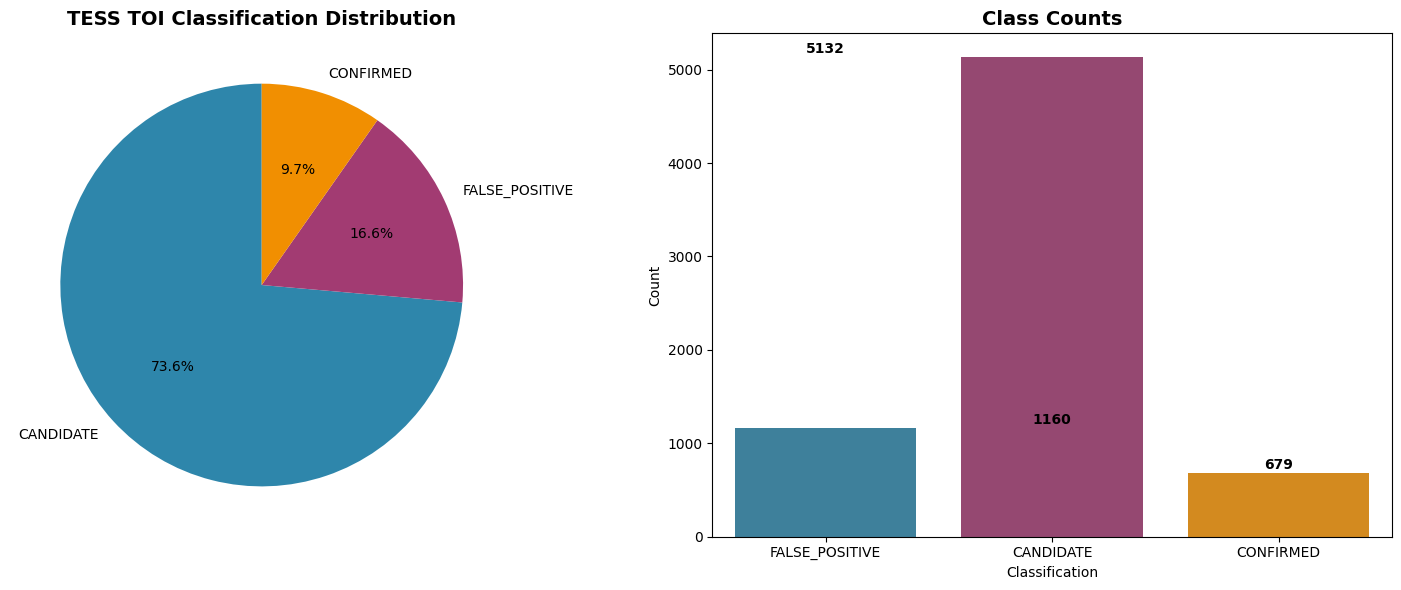

📊 Class Distribution:
  CANDIDATE: 5132 samples (73.6%)
  FALSE_POSITIVE: 1160 samples (16.6%)
  CONFIRMED: 679 samples (9.7%)
⚖️  Class balance ratio: 0.132
⚠️  WARNING: Significant class imbalance detected! Consider resampling techniques.


In [6]:
# ---- TESS TOI EXPLORATORY DATA ANALYSIS ----
print("=== TESS TOI EXPLORATORY DATA ANALYSIS ===\n")

# Set up the plotting environment
plt.style.use('default')
fig_size = (15, 10)

# 1. CLASS BALANCE ANALYSIS
print("1️⃣ Class Balance Analysis")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
class_counts = df_clean['disposition_clean'].value_counts()
colors = ['#2E86AB', '#A23B72', '#F18F01']
axes[0].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[0].set_title('TESS TOI Classification Distribution', fontsize=14, fontweight='bold')

# Bar plot with counts
sns.countplot(data=df_clean, x='disposition_clean', palette=colors, ax=axes[1])
axes[1].set_title('Class Counts', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classification')
axes[1].set_ylabel('Count')

# Add count labels on bars
for i, v in enumerate(class_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print class statistics
print("📊 Class Distribution:")
for cls, count in class_counts.items():
    pct = (count / len(df_clean)) * 100
    print(f"  {cls}: {count} samples ({pct:.1f}%)")

# Check for class imbalance
min_class_ratio = class_counts.min() / class_counts.max()
print(f"⚖️  Class balance ratio: {min_class_ratio:.3f}")
if min_class_ratio < 0.3:
    print("⚠️  WARNING: Significant class imbalance detected! Consider resampling techniques.")
else:
    print("✅ Classes are reasonably balanced.")


2️⃣ Distribution Analysis of Key TESS Features


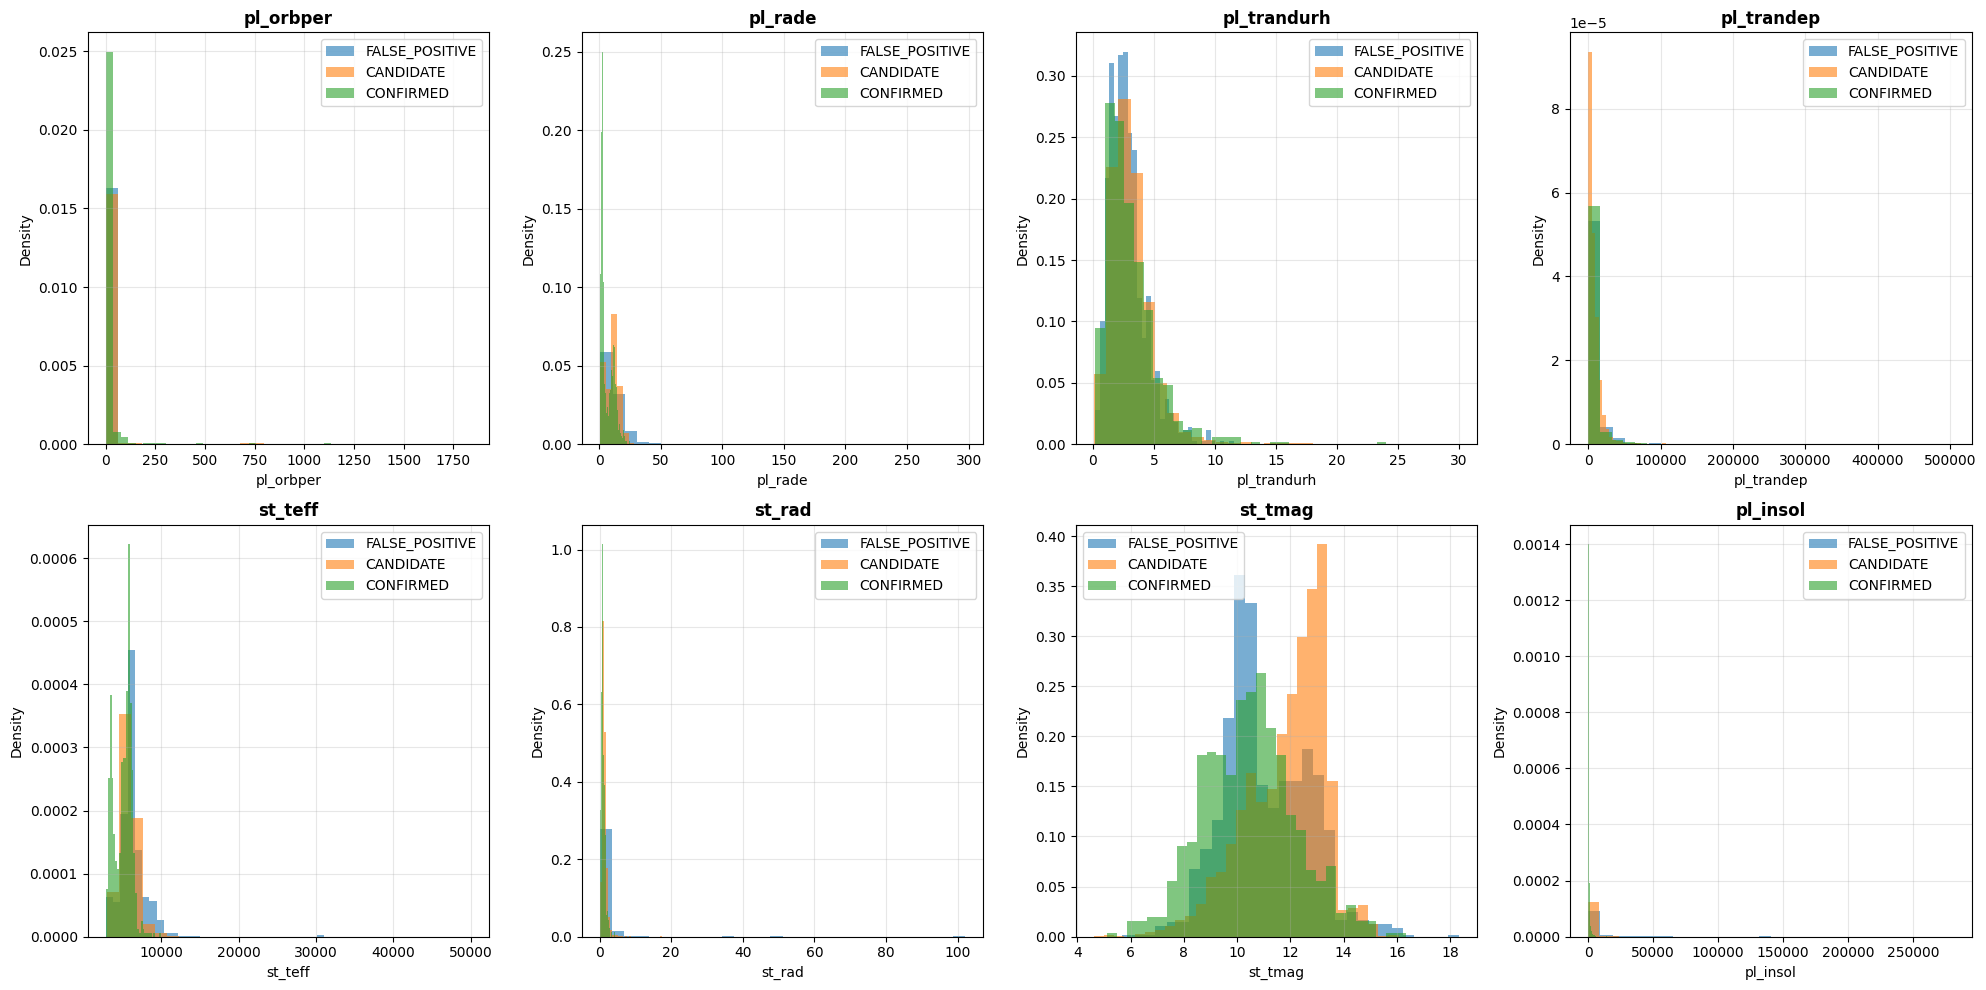

📈 Statistical Summary of Key TESS Features:
       pl_orbper   pl_rade  pl_trandurh  pl_trandep    st_teff    st_rad  \
count   6971.000  6971.000     6971.000    6971.000   6971.000  6971.000   
mean      18.104    10.210        3.106    8102.067   5779.294     1.389   
std       99.355     8.422        1.882   15438.130   1403.220     1.600   
min        0.164     0.553        0.101      24.583   2828.000     0.115   
25%        2.615     4.668        1.902    1367.000   5205.900     0.900   
50%        4.138    10.497        2.771    4700.000   5791.000     1.230   
75%        7.870    13.690        3.835   10310.000   6290.000     1.627   
max     1837.890   297.112       30.016  504062.380  50000.000   102.030   

        st_tmag    pl_insol  
count  6971.000    6971.000  
mean     11.591    2186.638  
std       1.626   10938.676  
min       4.628       0.000  
25%      10.410      84.854  
50%      11.882     353.314  
75%      12.880    1118.479  
max      18.332  280833.000  


In [7]:
# 2. DISTRIBUTIONS OF KEY VARIABLES
print(f"\n2️⃣ Distribution Analysis of Key TESS Features")

# Key features for TESS exoplanet detection
tess_key_features = [
    'pl_orbper', 'pl_rade', 'pl_trandurh', 'pl_trandep', 
    'st_teff', 'st_rad', 'st_tmag', 'pl_insol'
]

# Filter available features
available_key_features = [f for f in tess_key_features if f in df_clean.columns and df_clean[f].notna().sum() > 100]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(available_key_features[:8]):
    # Create subplot
    ax = axes[i]
    
    # Plot distributions by class
    for cls in df_clean['disposition_clean'].unique():
        data = df_clean[df_clean['disposition_clean'] == cls][feature].dropna()
        if len(data) > 0:
            ax.hist(data, alpha=0.6, label=cls, bins=30, density=True)
    
    ax.set_title(f'{feature}', fontweight='bold')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove empty subplots
for j in range(len(available_key_features), 8):
    axes[j].remove()

plt.tight_layout()
plt.show()

# Statistical summary
print("📈 Statistical Summary of Key TESS Features:")
if available_key_features:
    summary_stats = df_clean[available_key_features].describe()
    print(summary_stats.round(3))
else:
    print("No key features available for statistical summary.")


3️⃣ Correlation Analysis


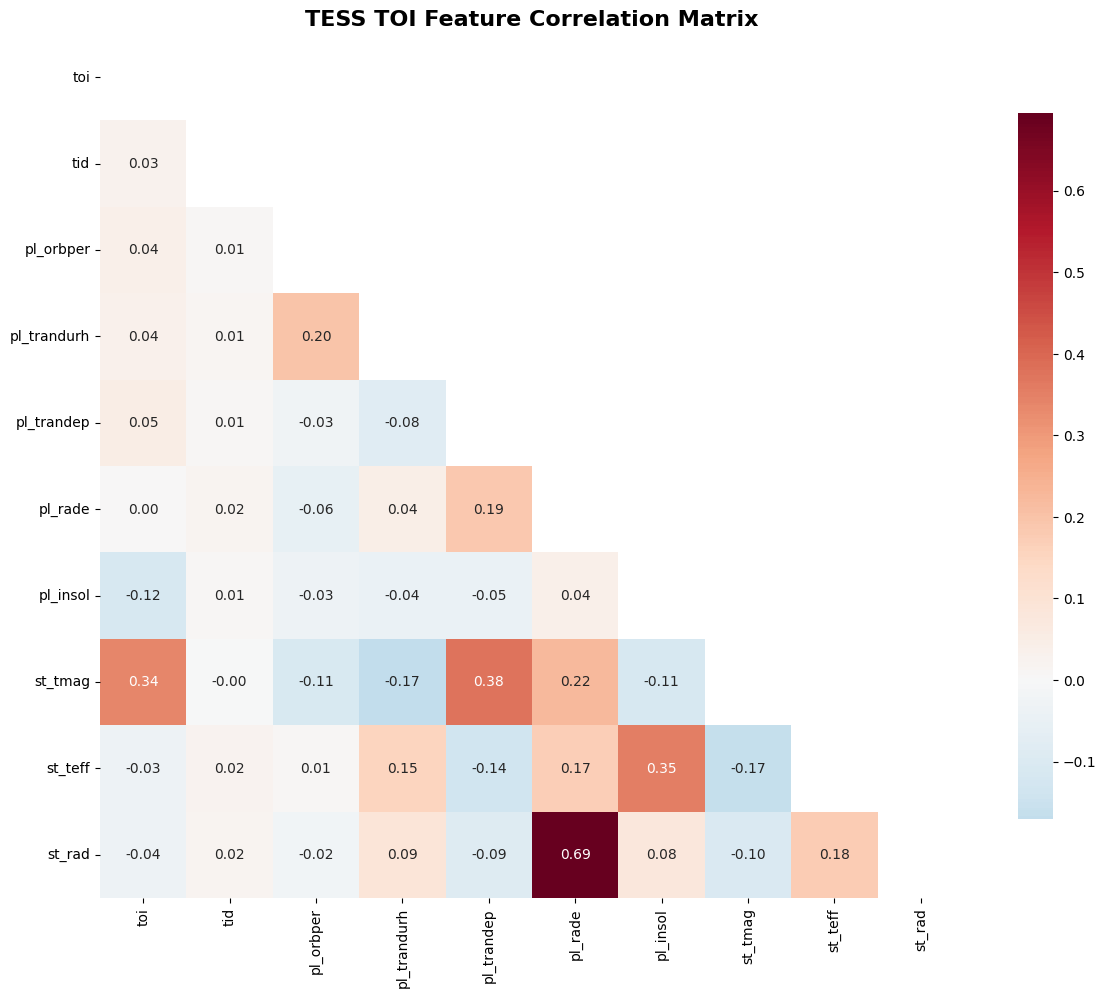

🔗 Highly Correlated Feature Pairs (|r| > 0.7):
  ✅ No highly correlated features found.


In [8]:
# 3. CORRELATION ANALYSIS
print(f"\n3️⃣ Correlation Analysis")

# Select numeric features for correlation
numeric_features = df_clean.select_dtypes(include=[np.number]).columns
correlation_features = [f for f in numeric_features if f in available_key_features + ['toi', 'tid']]

if len(correlation_features) > 1:
    # Calculate correlation matrix
    corr_matrix = df_clean[correlation_features].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('TESS TOI Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Identify highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    print("🔗 Highly Correlated Feature Pairs (|r| > 0.7):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  {feat1} ↔ {feat2}: {corr_val:.3f}")
    
    if not high_corr_pairs:
        print("  ✅ No highly correlated features found.")
else:
    print("⚠️ Insufficient numeric features for correlation analysis.")


4️⃣ Outlier Detection


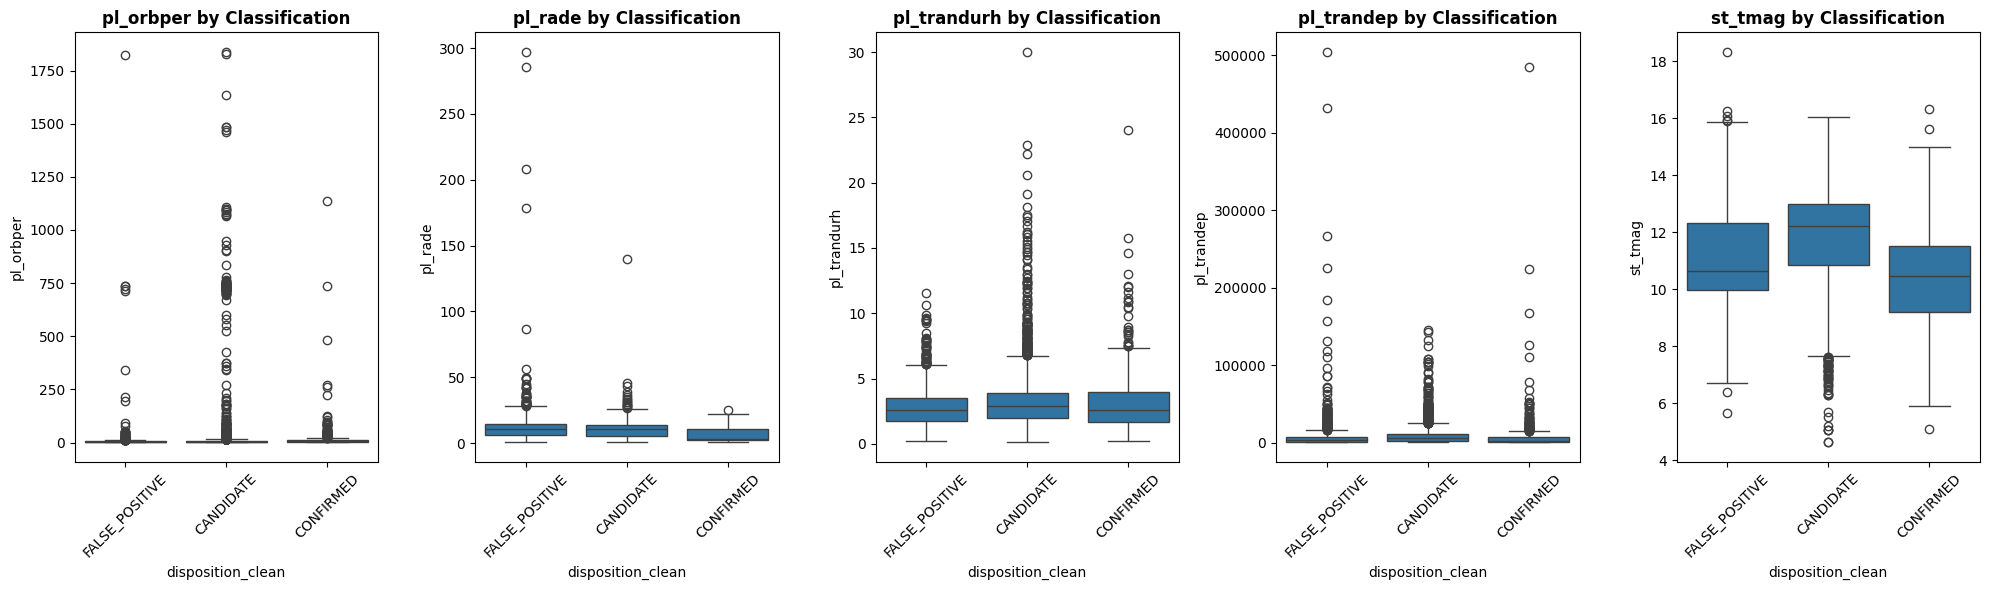

📊 Outlier Analysis (IQR method):
  pl_orbper: 729 outliers (10.5%)
  pl_rade: 60 outliers (0.9%)
  pl_trandurh: 232 outliers (3.3%)
  pl_trandep: 368 outliers (5.3%)
  st_tmag: 29 outliers (0.4%)

📏 Feature Ranges:
  pl_orbper: 0.164 to 1837.890
  pl_rade: 0.553 to 297.112
  pl_trandurh: 0.101 to 30.016
  pl_trandep: 24.583 to 504062.380
  st_tmag: 4.628 to 18.332


In [9]:
# 4. OUTLIER DETECTION
print(f"\n4️⃣ Outlier Detection")

# Key features for outlier analysis
tess_outlier_features = ['pl_orbper', 'pl_rade', 'pl_trandurh', 'pl_trandep', 'st_tmag']
available_outlier_features = [f for f in tess_outlier_features if f in df_clean.columns]

if available_outlier_features:
    # Box plots for outlier visualization
    fig, axes = plt.subplots(1, len(available_outlier_features), figsize=(20, 6))
    if len(available_outlier_features) == 1:
        axes = [axes]
    
    for i, feature in enumerate(available_outlier_features):
        sns.boxplot(data=df_clean, y=feature, x='disposition_clean', ax=axes[i])
        axes[i].set_title(f'{feature} by Classification', fontweight='bold')
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical outlier detection using IQR method
    print("📊 Outlier Analysis (IQR method):")
    outlier_summary = {}
    
    for feature in available_outlier_features:
        data = df_clean[feature].dropna()
        if len(data) > 0:
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            outlier_pct = (len(outliers) / len(data)) * 100
            
            outlier_summary[feature] = {
                'count': len(outliers),
                'percentage': outlier_pct,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            print(f"  {feature}: {len(outliers)} outliers ({outlier_pct:.1f}%)")
    
    # Feature ranges for context
    print(f"\n📏 Feature Ranges:")
    for feature in available_outlier_features:
        if df_clean[feature].notna().sum() > 0:
            min_val = df_clean[feature].min()
            max_val = df_clean[feature].max()
            print(f"  {feature}: {min_val:.3f} to {max_val:.3f}")
else:
    print("⚠️ No suitable features available for outlier analysis.")

# 6. Feature Engineering

Create new features and prepare TESS TOI data for machine learning algorithms.

In [10]:
# ---- TESS TOI FEATURE ENGINEERING ----
print("=== TESS TOI FEATURE ENGINEERING ===\n")

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import os

# Create feature engineering copy
df_features = df_clean.copy()

print("1️⃣ Creating Derived Features...")

# 1. Logarithmic transformations for skewed features
log_features = ['pl_orbper', 'pl_rade', 'pl_trandurh']
for feature in log_features:
    if feature in df_features.columns and df_features[feature].notna().sum() > 0:
        # Add small constant to handle zero values
        df_features[f'{feature}_log'] = np.log1p(df_features[feature])
        print(f"✅ Created {feature}_log")

# 2. Ratio and interaction features
if 'pl_trandep' in df_features.columns and 'pl_trandurh' in df_features.columns:
    df_features['depth_duration_ratio'] = df_features['pl_trandep'] / (df_features['pl_trandurh'] + 1e-6)
    print("✅ Created depth_duration_ratio")

if 'pl_rade' in df_features.columns and 'st_rad' in df_features.columns:
    df_features['planet_star_radius_ratio'] = df_features['pl_rade'] / (df_features['st_rad'] + 1e-6)
    print("✅ Created planet_star_radius_ratio")

if 'pl_insol' in df_features.columns:
    df_features['insol_log'] = np.log1p(df_features['pl_insol'])
    df_features['habitable_zone'] = ((df_features['pl_insol'] >= 0.5) & (df_features['pl_insol'] <= 2.0)).astype(int)
    print("✅ Created insol_log and habitable_zone flag")

# 3. Stellar quality indicators
if 'st_teff' in df_features.columns:
    df_features['stellar_temp_category'] = pd.cut(df_features['st_teff'], 
                                                 bins=[0, 4000, 5500, 7000, 50000], 
                                                 labels=['Cool', 'Warm', 'Hot', 'Very_Hot'])
    print("✅ Created stellar_temp_category")

# 4. TESS magnitude bins
if 'st_tmag' in df_features.columns:
    df_features['tmag_bright'] = (df_features['st_tmag'] < 10).astype(int)
    print("✅ Created tmag_bright flag")

print(f"\n📊 Features after engineering: {df_features.shape[1]} columns")

print(f"\n2️⃣ Preparing Features for ML...")

# Select features for ML
# Numeric features
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns and target-related columns
exclude_cols = ['rowid', 'toi', 'tid', 'disposition_clean', 'tfopwg_disp', 'pl_pnum',
                'ra', 'dec']  # Keep coordinates separate for now
tess_ml_numeric_features = [f for f in numeric_features if f not in exclude_cols]

# Key categorical features to encode
categorical_features_to_encode = ['stellar_temp_category']
available_categorical = [f for f in categorical_features_to_encode if f in df_features.columns]

print(f"📈 Selected {len(tess_ml_numeric_features)} numeric features for ML")
print(f"📝 Selected {len(available_categorical)} categorical features for encoding")

# Handle any remaining infinite or very large values
df_features[tess_ml_numeric_features] = df_features[tess_ml_numeric_features].replace([np.inf, -np.inf], np.nan)

# Final imputation for any new NaN values created during feature engineering
for col in tess_ml_numeric_features:
    if df_features[col].isnull().sum() > 0:
        median_val = df_features[col].median()
        df_features[col].fillna(median_val, inplace=True)

print("✅ Cleaned infinite values and remaining NaNs")

=== TESS TOI FEATURE ENGINEERING ===

1️⃣ Creating Derived Features...
✅ Created pl_orbper_log
✅ Created pl_rade_log
✅ Created pl_trandurh_log
✅ Created depth_duration_ratio
✅ Created planet_star_radius_ratio
✅ Created insol_log and habitable_zone flag
✅ Created stellar_temp_category
✅ Created tmag_bright flag

📊 Features after engineering: 97 columns

2️⃣ Preparing Features for ML...
📈 Selected 84 numeric features for ML
📝 Selected 1 categorical features for encoding
✅ Cleaned infinite values and remaining NaNs


c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\hadee\AppData\Local\Temp\ipykernel_11888\2286752753.py:75: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features[col].fillna(median_val, inplace=True)
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanme

In [11]:
# 3️⃣ Feature Scaling and Encoding
print(f"\n3️⃣ Feature Scaling and Encoding...")

# Prepare feature matrix X and target vector y
X = df_features[tess_ml_numeric_features].copy()
y = df_features['disposition_clean'].copy()

print(f"📊 Feature matrix shape: {X.shape}")
print(f"🎯 Target vector shape: {y.shape}")

# Encode categorical target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print("✅ Target encoding:")
for i, class_name in enumerate(le_target.classes_):
    count = (y_encoded == i).sum()
    print(f"  {class_name}: {i} ({count} samples)")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("✅ Applied StandardScaler to features")

# Alternative scaling for tree-based models
minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X)
X_minmax_df = pd.DataFrame(X_minmax, columns=X.columns, index=X.index)

print("✅ Applied MinMaxScaler (alternative for tree models)")

print(f"\n4️⃣ Data Splitting...")

# Stratified split to maintain class distribution
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled_df, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("📊 Data split summary:")
print(f"  Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Testing: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification
print("\n📈 Class distribution verification:")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    class_dist = np.bincount(y_split) / len(y_split)
    print(f"  {split_name}: {[f'{d:.3f}' for d in class_dist]}")

print("\n" + "="*50)


3️⃣ Feature Scaling and Encoding...
📊 Feature matrix shape: (6971, 84)
🎯 Target vector shape: (6971,)
✅ Target encoding:
  CANDIDATE: 0 (5132 samples)
  CONFIRMED: 1 (679 samples)
  FALSE_POSITIVE: 2 (1160 samples)
✅ Applied StandardScaler to features
✅ Applied MinMaxScaler (alternative for tree models)

4️⃣ Data Splitting...
📊 Data split summary:
  Training: 4182 samples (60.0%)
  Validation: 1394 samples (20.0%)
  Testing: 1395 samples (20.0%)

📈 Class distribution verification:
  Train: ['0.736', '0.097', '0.166']
  Val: ['0.736', '0.098', '0.166']
  Test: ['0.736', '0.097', '0.166']



c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\hadee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanm

# 7. Save Processed Dataset

Save the cleaned and processed TESS TOI data along with transformers for the ML phase.

In [12]:
# ---- SAVE TESS TOI PROCESSED DATASETS ----
print("=== SAVING TESS TOI PROCESSED DATASETS ===\n")

# Create TESS-specific directories
os.makedirs('data/processed/tess', exist_ok=True)
os.makedirs('artifacts/tess', exist_ok=True)

print("1️⃣ Saving TESS train/validation/test splits...")

# Save split datasets (StandardScaler version)
datasets = {
    'train': (X_train, y_train),
    'val': (X_val, y_val), 
    'test': (X_test, y_test)
}

for split_name, (X_split, y_split) in datasets.items():
    # Combine features and target
    split_df = X_split.copy()
    split_df['target'] = y_split
    split_df['target_name'] = le_target.inverse_transform(y_split)
    
    # Save to CSV with TESS prefix
    split_df.to_csv(f'data/processed/tess/tess_{split_name}.csv', index=False)
    print(f"✅ Saved data/processed/tess/tess_{split_name}.csv ({split_df.shape[0]} rows)")

# Save MinMax scaled version for tree-based models
X_train_mm, X_temp_mm, y_train_mm, y_temp_mm = train_test_split(
    X_minmax_df, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
)
X_val_mm, X_test_mm, y_val_mm, y_test_mm = train_test_split(
    X_temp_mm, y_temp_mm, test_size=0.5, random_state=42, stratify=y_temp_mm
)

datasets_mm = {
    'train_minmax': (X_train_mm, y_train_mm),
    'val_minmax': (X_val_mm, y_val_mm),
    'test_minmax': (X_test_mm, y_test_mm)
}

for split_name, (X_split, y_split) in datasets_mm.items():
    split_df = X_split.copy()
    split_df['target'] = y_split
    split_df['target_name'] = le_target.inverse_transform(y_split)
    split_df.to_csv(f'data/processed/tess/tess_{split_name}.csv', index=False)
    print(f"✅ Saved data/processed/tess/tess_{split_name}.csv")

print(f"\n2️⃣ Saving TESS transformers and metadata...")

# Save transformers
transformers = {
    'standard_scaler': scaler,
    'minmax_scaler': minmax_scaler,
    'label_encoder': le_target
}

for name, transformer in transformers.items():
    with open(f'artifacts/tess/tess_{name}.pkl', 'wb') as f:
        pickle.dump(transformer, f)
    print(f"✅ Saved artifacts/tess/tess_{name}.pkl")

# Save feature metadata
feature_metadata = {
    'dataset_name': 'TESS TOI',
    'feature_names': tess_ml_numeric_features,
    'n_features': len(tess_ml_numeric_features),
    'target_classes': le_target.classes_.tolist(),
    'n_classes': len(le_target.classes_),
    'dataset_shape': df_features.shape,
    'split_sizes': {
        'train': len(X_train),
        'val': len(X_val),
        'test': len(X_test)
    }
}

with open('artifacts/tess/tess_feature_metadata.pkl', 'wb') as f:
    pickle.dump(feature_metadata, f)
print("✅ Saved artifacts/tess/tess_feature_metadata.pkl")

print(f"\n3️⃣ Saving full processed TESS dataset...")
# Save the complete processed dataset
df_features.to_csv('data/processed/tess/tess_full_processed.csv', index=False)
print(f"✅ Saved data/processed/tess/tess_full_processed.csv ({df_features.shape[0]} rows × {df_features.shape[1]} cols)")

print(f"\n✅ All TESS TOI datasets and artifacts saved successfully!")
print(f"📁 Files created:")
print(f"  📊 data/processed/tess/tess_train.csv")
print(f"  📊 data/processed/tess/tess_val.csv") 
print(f"  📊 data/processed/tess/tess_test.csv")
print(f"  📊 data/processed/tess/tess_*_minmax.csv (for tree models)")
print(f"  📊 data/processed/tess/tess_full_processed.csv")
print(f"  🔧 artifacts/tess/tess_standard_scaler.pkl")
print(f"  🔧 artifacts/tess/tess_minmax_scaler.pkl")
print(f"  🔧 artifacts/tess/tess_label_encoder.pkl")
print(f"  🔧 artifacts/tess/tess_feature_metadata.pkl")

=== SAVING TESS TOI PROCESSED DATASETS ===

1️⃣ Saving TESS train/validation/test splits...
✅ Saved data/processed/tess/tess_train.csv (4182 rows)
✅ Saved data/processed/tess/tess_val.csv (1394 rows)
✅ Saved data/processed/tess/tess_test.csv (1395 rows)
✅ Saved data/processed/tess/tess_train_minmax.csv
✅ Saved data/processed/tess/tess_val_minmax.csv
✅ Saved data/processed/tess/tess_test_minmax.csv

2️⃣ Saving TESS transformers and metadata...
✅ Saved artifacts/tess/tess_standard_scaler.pkl
✅ Saved artifacts/tess/tess_minmax_scaler.pkl
✅ Saved artifacts/tess/tess_label_encoder.pkl
✅ Saved artifacts/tess/tess_feature_metadata.pkl

3️⃣ Saving full processed TESS dataset...
✅ Saved data/processed/tess/tess_full_processed.csv (6971 rows × 97 cols)

✅ All TESS TOI datasets and artifacts saved successfully!
📁 Files created:
  📊 data/processed/tess/tess_train.csv
  📊 data/processed/tess/tess_val.csv
  📊 data/processed/tess/tess_test.csv
  📊 data/processed/tess/tess_*_minmax.csv (for tree model

# 8. Dataset Documentation & ML Readiness Summary

Final summary and documentation for the Machine Learning team.

In [13]:
# ---- TESS TOI DATASET DOCUMENTATION & ML READINESS ----
print("=== TESS TOI EXOPLANET DATASET - ML READINESS REPORT ===")
print("🚀 NASA Space Apps Challenge - TESS TOI Exoplanet Detection\n")

print("="*60)
print("📋 DATASET SUMMARY")
print("="*60)
print(f"📊 Original Dataset: {initial_shape[0]} rows × {initial_shape[1]} columns")
print(f"📊 Processed Dataset: {df_features.shape[0]} rows × {df_features.shape[1]} columns")
print(f"📉 Data Reduction: {((initial_shape[0] - df_features.shape[0])/initial_shape[0]*100):.1f}% rows removed")
print(f"🎯 Target Variable: disposition_clean (3 classes)")
print(f"🔢 Features for ML: {len(tess_ml_numeric_features)} numeric features")

print(f"\n📈 Class Distribution:")
final_class_counts = df_features['disposition_clean'].value_counts()
for cls, count in final_class_counts.items():
    pct = (count / len(df_features)) * 100
    print(f"  • {cls}: {count:,} samples ({pct:.1f}%)")

print(f"\n" + "="*60)
print("🔧 FEATURE ENGINEERING SUMMARY")
print("="*60)
print("✅ Applied transformations:")
print("  • Log transformations: pl_orbper, pl_rade, pl_trandurh")
print("  • Ratio features: depth_duration_ratio, planet_star_radius_ratio") 
print("  • Derived features: habitable_zone flag, stellar_temp_category")
print("  • TESS-specific: tmag_bright flag")
print("  • Scaling: StandardScaler (default) + MinMaxScaler (trees)")

print(f"\n📊 Key Features for TESS Exoplanet Detection:")
tess_top_features = ['pl_orbper', 'pl_rade', 'pl_trandurh', 'pl_trandep', 
                     'st_teff', 'st_tmag', 'depth_duration_ratio', 'habitable_zone']
available_top = [f for f in tess_top_features if f in tess_ml_numeric_features]
for i, feature in enumerate(available_top[:8], 1):
    print(f"  {i}. {feature}")

print(f"\n" + "="*60)
print("💾 OUTPUT FILES FOR ML TEAM")
print("="*60)
print("📁 Ready-to-use TESS datasets:")
print("  🟢 data/processed/tess/tess_train.csv")
print("  🟡 data/processed/tess/tess_val.csv")
print("  🔴 data/processed/tess/tess_test.csv")
print("  🌳 data/processed/tess/tess_*_minmax.csv (for tree models)")

print(f"\n🔧 TESS preprocessing artifacts:")
print("  📦 artifacts/tess/tess_standard_scaler.pkl")
print("  📦 artifacts/tess/tess_minmax_scaler.pkl")
print("  📦 artifacts/tess/tess_label_encoder.pkl")
print("  📦 artifacts/tess/tess_feature_metadata.pkl")

print(f"\n" + "="*60)
print("🎯 ML RECOMMENDATIONS")
print("="*60)
print("🤖 Suggested ML approaches:")
print("  1. Random Forest/XGBoost (use MinMax scaled data)")
print("  2. SVM/Logistic Regression (use Standard scaled data)")
print("  3. Neural Networks (use Standard scaled data)")
print("  4. Ensemble methods combining multiple approaches")

print(f"\n⚖️  Class Imbalance Strategy:")
min_class_ratio = final_class_counts.min() / final_class_counts.max()
if min_class_ratio < 0.3:
    print("  ⚠️  Consider: SMOTE, class weights, or stratified sampling")
else:
    print("  ✅ Classes reasonably balanced - proceed with standard training")

print(f"\n🎨 Evaluation Metrics:")
print("  • Primary: F1-score (macro/weighted)")
print("  • Secondary: Precision, Recall, ROC-AUC")
print("  • Classification Report with confusion matrix")

print(f"\n🔍 Next Steps for ML Team:")
print("  1. Load processed TESS datasets from data/processed/tess/")
print("  2. Load transformers from artifacts/tess/ for new data")
print("  3. Compare with Kepler results for cross-mission validation")
print("  4. Implement ensemble methods combining TESS + Kepler")
print("  5. Tune hyperparameters for best models")
print("  6. Generate final predictions on test set")

print(f"\n" + "="*60)
print("✅ TESS TOI DATASET PROCESSING COMPLETE!")
print("🚀 Ready for Machine Learning Phase!")
print("="*60)

=== TESS TOI EXOPLANET DATASET - ML READINESS REPORT ===
🚀 NASA Space Apps Challenge - TESS TOI Exoplanet Detection

📋 DATASET SUMMARY
📊 Original Dataset: 7668 rows × 87 columns
📊 Processed Dataset: 6971 rows × 97 columns
📉 Data Reduction: 9.1% rows removed
🎯 Target Variable: disposition_clean (3 classes)
🔢 Features for ML: 84 numeric features

📈 Class Distribution:
  • CANDIDATE: 5,132 samples (73.6%)
  • FALSE_POSITIVE: 1,160 samples (16.6%)
  • CONFIRMED: 679 samples (9.7%)

🔧 FEATURE ENGINEERING SUMMARY
✅ Applied transformations:
  • Log transformations: pl_orbper, pl_rade, pl_trandurh
  • Ratio features: depth_duration_ratio, planet_star_radius_ratio
  • Derived features: habitable_zone flag, stellar_temp_category
  • TESS-specific: tmag_bright flag
  • Scaling: StandardScaler (default) + MinMaxScaler (trees)

📊 Key Features for TESS Exoplanet Detection:
  1. pl_orbper
  2. pl_rade
  3. pl_trandurh
  4. pl_trandep
  5. st_teff
  6. st_tmag
  7. depth_duration_ratio
  8. habitable_

In [14]:
# ---- FINAL TESS VERIFICATION ----
print("🔍 FINAL TESS VERIFICATION & SUMMARY")
print("="*50)

# Verify file creation
tess_files_to_check = [
    'data/processed/tess/tess_train.csv',
    'data/processed/tess/tess_val.csv', 
    'data/processed/tess/tess_test.csv',
    'artifacts/tess/tess_standard_scaler.pkl',
    'artifacts/tess/tess_label_encoder.pkl'
]

print("📁 TESS File Verification:")
for file_path in tess_files_to_check:
    exists = "✅" if os.path.exists(file_path) else "❌"
    size = f" ({os.path.getsize(file_path)/1024:.1f}KB)" if os.path.exists(file_path) else ""
    print(f"  {exists} {file_path}{size}")

# Quick data sanity check
print(f"\n🧪 TESS Data Sanity Check:")
if os.path.exists('data/processed/tess/tess_train.csv'):
    tess_train_check = pd.read_csv('data/processed/tess/tess_train.csv')
    print(f"  Training set: {tess_train_check.shape[0]} rows × {tess_train_check.shape[1]} cols")
    print(f"  Features: {tess_train_check.shape[1] - 2} (excluding target columns)")
    print(f"  Target distribution: {tess_train_check['target'].value_counts().to_dict()}")
    print(f"  Missing values: {tess_train_check.isnull().sum().sum()}")

print(f"\n🎯 TESS Success Metrics:")
print(f"  ✅ Dataset cleaned: {initial_shape[0]} → {df_features.shape[0]} rows")
print(f"  ✅ Features engineered: {initial_shape[1]} → {len(tess_ml_numeric_features)} ML features")  
print(f"  ✅ Data splits created: 60/20/20 train/val/test")
print(f"  ✅ Transformers saved: StandardScaler + MinMaxScaler")
print(f"  ✅ TESS-specific artifacts organized in tess/ subdirectories")

print(f"\n🚀 TESS TOI PROJECT STATUS: COMPLETE!")
print(f"Ready for Machine Learning phase! 🌟")
print("="*50)

🔍 FINAL TESS VERIFICATION & SUMMARY
📁 TESS File Verification:
  ✅ data/processed/tess/tess_train.csv (4432.8KB)
  ✅ data/processed/tess/tess_val.csv (1478.3KB)
  ✅ data/processed/tess/tess_test.csv (1478.9KB)
  ✅ artifacts/tess/tess_standard_scaler.pkl (4.3KB)
  ✅ artifacts/tess/tess_label_encoder.pkl (0.3KB)

🧪 TESS Data Sanity Check:
  Training set: 4182 rows × 86 cols
  Features: 84 (excluding target columns)
  Target distribution: {0: 3079, 2: 696, 1: 407}
  Missing values: 50184

🎯 TESS Success Metrics:
  ✅ Dataset cleaned: 7668 → 6971 rows
  ✅ Features engineered: 87 → 84 ML features
  ✅ Data splits created: 60/20/20 train/val/test
  ✅ Transformers saved: StandardScaler + MinMaxScaler
  ✅ TESS-specific artifacts organized in tess/ subdirectories

🚀 TESS TOI PROJECT STATUS: COMPLETE!
Ready for Machine Learning phase! 🌟
